https://movie.douban.com/subject/26416062/comments?start=0&limit=20
https://movie.douban.com/subject/26416062/comments?start=20&limit=20
https://movie.douban.com/subject/26416062/comments?start=40&limit=20
https://movie.douban.com/subject/26416062/comments?start=60&limit=20
https://movie.douban.com/subject/26416062/comments?start=80&limit=20
https://movie.douban.com/subject/26416062/comments?start=100&limit=20
https://movie.douban.com/subject/26416062/comments?start=120&limit=20
https://movie.douban.com/subject/26416062/comments?start=140&limit=20
https://movie.douban.com/subject/26416062/comments?start=160&limit=20
https://movie.douban.com/subject/26416062/comments?start=180&limit=20


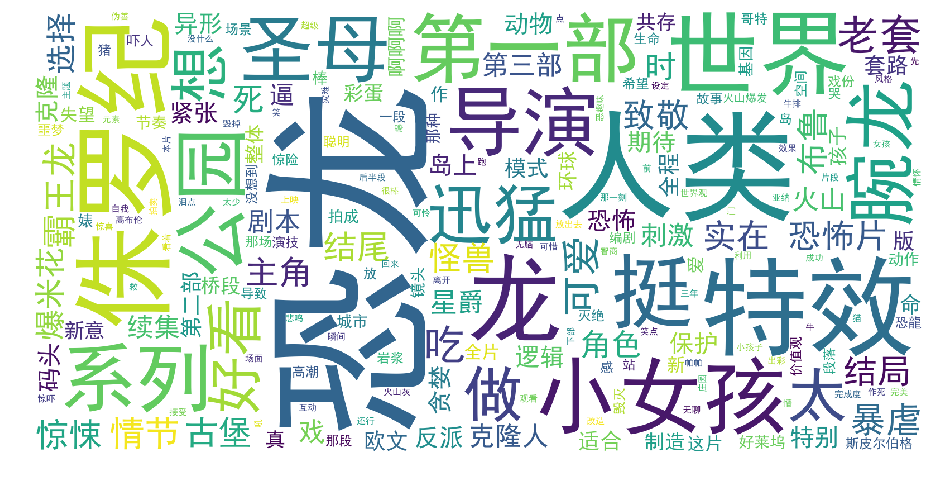

In [47]:
#coding:utf-8
__author__ = 'hang'
 
import warnings
warnings.filterwarnings("ignore")
import jieba    #分词包
import jieba.analyse
import numpy    #numpy计算包
import codecs   #codecs提供的open方法来指定打开的文件的语言编码，它会在读取的时候自动转换为内部unicode 
import re
import pandas as pd  
import matplotlib.pyplot as plt
from urllib import request
from bs4 import BeautifulSoup as bs
%matplotlib inline
 
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)
from wordcloud import WordCloud#词云包
 
#分析网页函数
def getNowPlayingMovie_list():   
    resp = request.urlopen('https://movie.douban.com/nowplaying/hangzhou/')        
    html_data = resp.read().decode('utf-8')    
    soup = bs(html_data, 'html.parser')    
    nowplaying_movie = soup.find_all('div', id='nowplaying')        
    nowplaying_movie_list = nowplaying_movie[0].find_all('li', class_='list-item')    
    nowplaying_list = []    
    for item in nowplaying_movie_list:        
        nowplaying_dict = {}        
        nowplaying_dict['id'] = item['data-subject']       
        for tag_img_item in item.find_all('img'):            
            nowplaying_dict['name'] = tag_img_item['alt']            
            nowplaying_list.append(nowplaying_dict)    
    return nowplaying_list
 
#爬取评论函数
def getCommentsById(movieId, pageNum): 
    eachCommentList = [];
    if pageNum>0: 
         start = (pageNum-1) * 20
    else: 
        return False
    requrl = 'https://movie.douban.com/subject/' + movieId + '/comments' +'?' +'start=' + str(start) + '&limit=20'
    print(requrl)
    resp = request.urlopen(requrl)
    html_data = resp.read().decode('utf-8')
    soup = bs(html_data, 'html.parser')
    comment_div_lits = soup.find_all('div', class_='comment')
    for item in comment_div_lits: 
        if item.find_all('p')[0].string is not None:     
            eachCommentList.append(item.find_all('p')[0].string)
    return eachCommentList
 
def main():
    #循环获取第一个电影的前10页评论
    commentList = []
    NowPlayingMovie_list = getNowPlayingMovie_list()
    for i in range(10):    
        num = i + 1
        commentList_temp = getCommentsById(NowPlayingMovie_list[0]['id'], num)
        commentList.append(commentList_temp)
 
    #将列表中的数据转换为字符串
    comments = ''
    for k in range(len(commentList)):
        comments = comments + (str(commentList[k])).strip()
 
    #使用正则表达式去除标点符号
    pattern = re.compile(r'[\u4e00-\u9fa5]+')
    filterdata = re.findall(pattern, comments)
    cleaned_comments = ''.join(filterdata)
 
    #使用结巴分词进行中文分词
    segment = jieba.lcut(cleaned_comments)
    words_df = pd.DataFrame({'segment':segment})
 
    #去掉停用词
    stopwords = [line.strip() for line in open("input\stopwords.txt", 'r', encoding='utf-8').readlines()] 
    #stopwords = pd.read_csv("input\stopwords.txt",index_col=False,quoting=3,sep="\t",names=['stopword'], encoding='utf-8')#quoting=3全不引用
    words_df = words_df[~words_df.segment.isin(stopwords)]

    #统计词频
    words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数":numpy.size})
    words_stat = words_stat.reset_index().sort_values(by=["计数"],ascending=False)
 
    #用词云进行显示
    wordcloud = WordCloud(font_path="simhei.ttf",background_color="white",max_font_size=80, scale=4.0)
    word_frequence = {x[0]:x[1] for x in words_stat.head(1000).values}
 
    word_frequence_list = []
    for key in word_frequence:
        temp = (key,word_frequence[key])
        word_frequence_list.append(temp)
 
    wordcloud = wordcloud.fit_words(word_frequence)
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.savefig('WordCloud.png', dpi=96)
    plt.show()
 
#主函数
main()

1   League of Legends   98245
2   Dota 2   82756
3   Fortnite   50709
4   Realm Royale   44505
5   IRL   33454
6   PLAYERUNKNOWN'S BATTLEGROUNDS   27939
7   Hearthstone   21847
8   Overwatch   21570
9   Diablo III: Reaper of Souls   12776
10   Music   11322
30   Talk Shows   2948
60   House Flipper   1111
90   The Elder Scrolls V: Skyrim   566
120   State of Decay 2   329
150   The Sims 4   220
180   Moonlighter   127
210   Dark Souls II: Scholar of the First Sin   86
240   Bloons TD 6   69
270   The Great Merchant   56


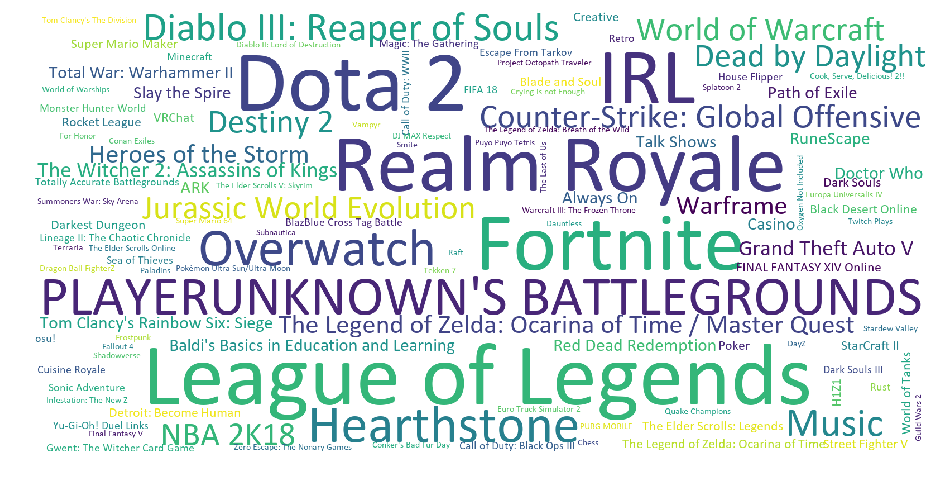

In [48]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
 
import requests
import json
from wordcloud import WordCloud
from random import randint
import math
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)

url = 'https://gql.twitch.tv/gql'
game_number_need = 300
display_per_page = 30
game_cursor = ""
headers = {'content-type': "application/json", "Client-Id":"kimne78kx3ncx6brgo4mv6wki5h1ko"}
game_name_list = []
game_viewer_list = []
i = 0
while game_number_need > 0: 
    body = {"variables":{"limit":display_per_page,"directoryFilters":["GAMES"],"directorySort":"VIEWER_COUNT", "cursor":game_cursor},"extensions":{},"operationName":"BrowsePage_AllDirectories","query":"query BrowsePage_AllDirectories($limit: Int, $cursor: Cursor, $directoryFilters: [DirectoryFilter!], $directorySort: DirectorySort) {\n  directories(first: $limit, after: $cursor, filterBySet: $directoryFilters, sortBy: $directorySort) {\n    edges {\n      cursor\n      node {\n        id\n        displayName\n        name\n        avatarURL(width: 285, height: 380)\n        viewersCount\n        directoryType\n        ... on Game {\n          activeDropCampaigns {\n            applicableChannels {\n              id\n              __typename\n            }\n            __typename\n          }\n          __typename\n        }\n        __typename\n      }\n      __typename\n    }\n    pageInfo {\n      hasNextPage\n      __typename\n    }\n    __typename\n  }\n}\n"}
    response = requests.post(url, data = json.dumps(body), headers = headers)
    json_dict = json.loads(response.text)
    for item in json_dict.get('data').get('directories').get('edges'):
        game_name_list.append(item.get('node').get('displayName'))
        game_viewer_list.append(math.log(item.get('node').get('viewersCount'),10))
        game_cursor = item.get('cursor')
        i += 1
        if i <= 10 or i % 30 == 0:
            print(i, ' ', item.get('node').get('displayName'), ' ', item.get('node').get('viewersCount'))
    game_number_need -= display_per_page
game_list = dict(zip(game_name_list, game_viewer_list))
#print(game_list)

wordcloud = WordCloud(font_path="calibri.ttf", background_color="white", max_font_size=40, scale=4.0, prefer_horizontal=0.9, relative_scaling=1.0)
wordcloud = wordcloud.fit_words(game_list)
plt.axis("off")
plt.imshow(wordcloud)
plt.savefig('WordCloud.png', dpi = 20)
plt.show()